# Participant report

This section aims at gathering the different information that could appear in an administration report. It will most likely be hierarchical with the most important information presented firt, followed by
the details.

1) Demographics of the participant and clinical data if available
2) Quality of the administration: missing data, compliance score
3) Prediction for the participant and interpretability resultd


If time allows, and if we think ut's necessary we can add (i) the distribution of the participant's face proportion of the screen and the actual participant point, (ii) Percentage of frame where the face where detected, etc. 

In [22]:
run init.ipynb

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Done.


In [37]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#0:1F77B4-46.2:FFFFFF-100:FF7F0E
    (0.000, (0.122, 0.467, 0.706)),
    (0.462, (1.000, 1.000, 1.000)),
    (1.000, (1.000, 0.498, 0.055))))

def display_interaction_summary(matrix_shap):
    
    principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
    interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

    dict_shap = {}
    for i, feat in enumerate(exp.features_name):

        main_effect = np.abs(matrix_shap)[i,i]
        interaction_effect = np.abs(matrix_shap)[i].sum() - main_effect

        row_shap = deepcopy(np.abs(matrix_shap)[i])
        row_shap[i] = 0
        first_interaction = np.max(row_shap)
        first_interaction_name = exp.features_name[np.argmax(row_shap)]

        dict_shap[feat] = {'total': main_effect+interaction_effect, 'main': main_effect, 'interaction': interaction_effect, 'first_interaction': first_interaction, 'first_interaction_name': first_interaction_name}
    final_interactions_summary = pd.DataFrame(dict_shap).transpose().sort_values('total', ascending=False)
    final_interactions_summary.append(pd.DataFrame([[100, principal_effect_sum, interaction_effect_sum, '', '']], index=['SUM'], columns = final_interactions_summary.columns))

    return final_interactions_summary

**We first need to retrieve the participant's data**

388 administrations left.


,id
diagnosis,
0.0,332
1.0,56


,experiment_name,AUROC,AUC-PR,AUC-PR-Gain,AUC-PR-Corrected,AUC-PR-Gain-Corrected,F1 score (2 PPVxTPR/(PPV+TPR)),F1 score Corrected,F2,F2 Corrected,Accuracy,Matthews correlation coefficient (MCC),"Sensitivity, recall, hit rate, or true positive rate (TPR)","Specificity, selectivity or true negative rate (TNR)",Precision or positive predictive value (PPV),Corrected Precision or positive predictive value (PPV),Negative predictive value (NPV),Miss rate or false negative rate (FNR),False discovery rate (FDR=1-PPV),False omission rate (FOR=1-NPV),TP,TN,FP,FN
0,FINAL,0.887,0.657,0.937,0.324,0.991,0.686,0.122,0.686,0.254,0.719,0.419,0.893,0.69,0.327,0.063,0.974,0.107,0.673,0.026,50,229,103,6


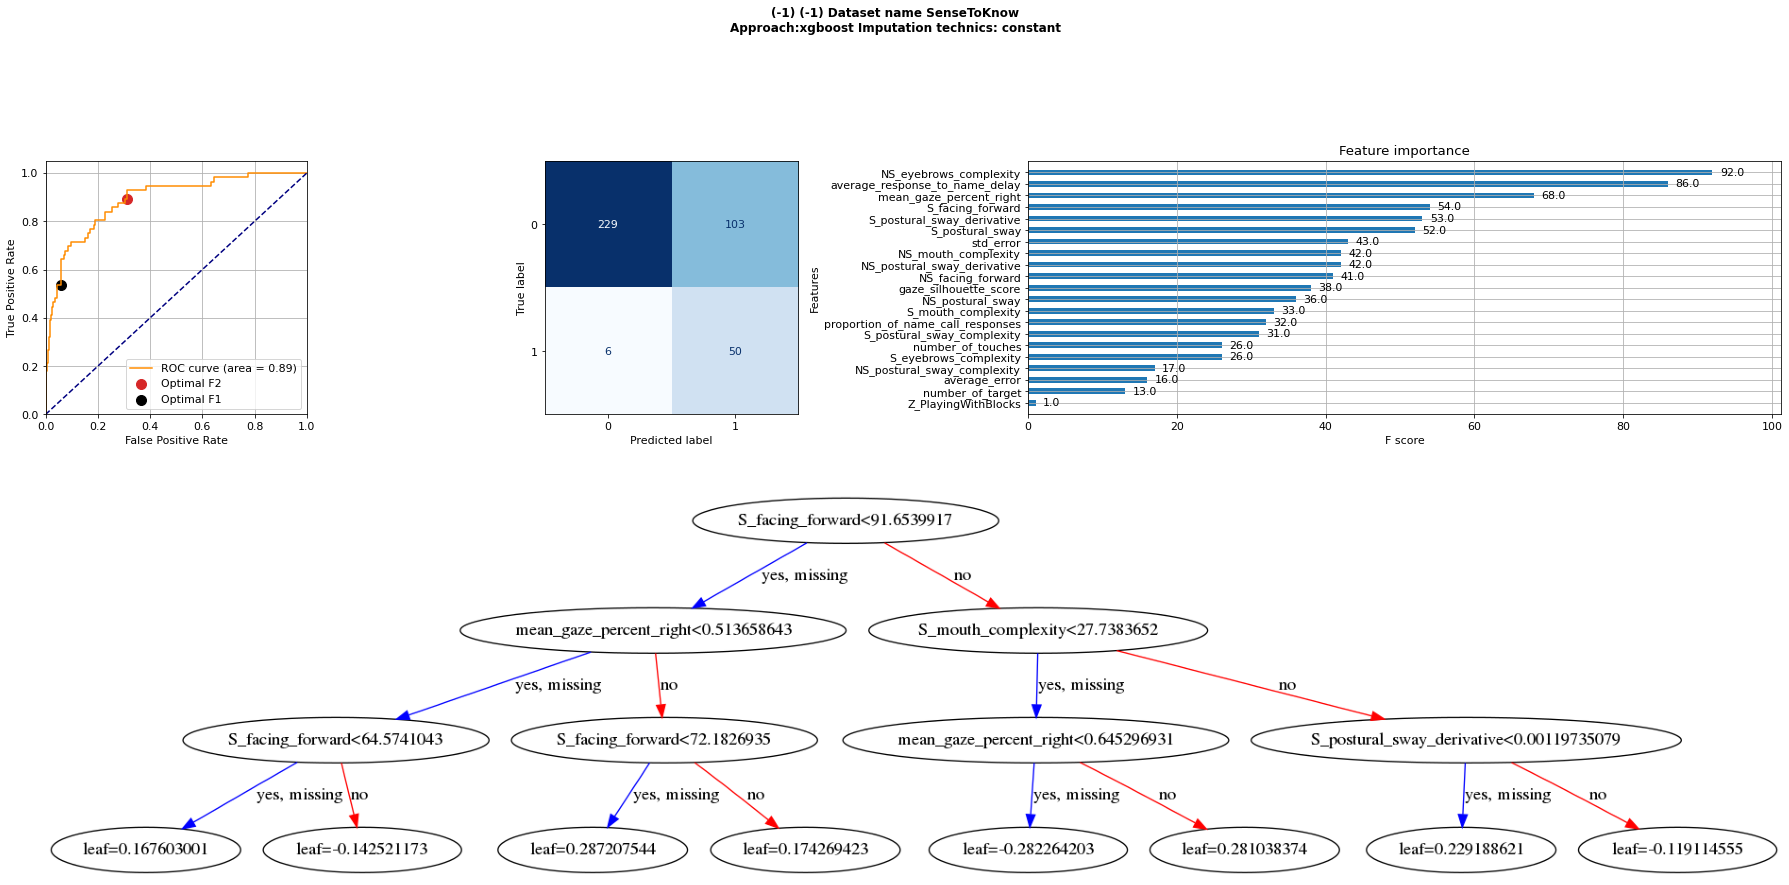

In [31]:
xgboost_hyperparameters = {'scale_pos_weight':True,#np.sum(data.y_train==0)/np.sum(data.y_train==1), 
                            'max_depth' : 3,
                            'learning_rate' : 0.15, 
                            'gamma': 0.1,
                            'n_estimators': 200,
                            'min_child_weight': 1,
                            'reg_lambda': 0.1}
    
use_weight = False
if use_weight:
    weighted_confidence_score = np.load(os.path.join(DATA_DIR, 'weight_multimodal.npy'))
else:
    weighted_confidence_score = None
    
    
df =  pd.read_csv(AUTISM_DATA_PATH)

data = Dataset(df=df, 
               missing_data_handling='imputation',
               imputation_method='constant',
               sampling_method='without',
               scenario = 'multimodal_2023', 
               features_name = deepcopy(DEFAULT_PREDICTORS_BY_TYPES['All']),
               scale_data=False, 
               use_missing_indicator_variables=USE_MISSING_INDICATOR_PREDICTORS,
               verbosity=1, 
               proportion_train=1)

exp = Experiments(data.dataset_name,
                  dataset=data, 
                  approach='xgboost', 
                  previous_experiment=None,        
                  debug=False, 
                  experiment_folder_name='PAPER', 
                  model_hyperparameters=xgboost_hyperparameters,
                  experiment_name = 'FINAL',
                  verbosity=1, 
                  save_experiment=False)

exp.fit_predict(num_cv=5, sample_weight=weighted_confidence_score)
exp.predictions_df['sample_weight'] = weighted_confidence_score
exp.plot()



**Select a promising participant to showcase**

In [20]:
exp.predictions_df.sort_values(by='y_pred', ascending=False).head()

,mean_gaze_percent_right,gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,S_postural_sway_complexity,NS_postural_sway_complexity,S_facing_forward,NS_facing_forward,S_eyebrows_complexity,NS_eyebrows_complexity,S_mouth_complexity,NS_mouth_complexity,std_error,number_of_touches,number_of_target,average_error,Z_PlayingWithBlocks,Z_FunAtThePark,Z_BlowingBubbles,Z_RhymesAndToys,y_true,y_pred,TN,TP,FP,FN,pred_class,sample_weight
382,0.819843,0.531763,1.000000,0.767433,7.946785,5.887994,0.033473,0.032651,0.000000,0.000000,36.730425,49.274152,23.211527,17.513519,17.851734,13.564486,2.204124,16.0,16.0,4.969821,0.0,0.0,1.0,0.0,1.0,0.999173,0,1,0,0,TP,None
67,0.580661,0.461836,0.333333,0.934267,5.002257,1.275072,0.030330,0.005013,2.487151,1.609438,48.524315,60.136997,20.929317,26.090395,18.125196,26.626478,4.490219,6.0,6.0,6.745409,0.0,0.0,0.0,0.0,1.0,0.998772,0,1,0,0,TP,None
14,0.617876,0.514620,0.666667,1.735067,2.722279,3.209192,0.011716,0.013588,3.094245,0.000000,73.800057,53.170227,30.779673,18.292719,30.577063,14.939351,5.535775,22.0,15.0,9.086770,0.0,0.0,0.0,0.0,1.0,0.998469,0,1,0,0,TP,None
24,0.568528,0.273053,0.500000,1.568233,1.344965,0.418894,0.003942,0.001967,3.438220,2.125048,37.764991,41.570463,13.549890,17.672448,11.982748,15.101356,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.998377,0,1,0,0,TP,None
144,0.663503,0.589771,0.333333,3.036367,0.307655,0.280161,0.001071,0.000987,1.841305,3.459907,25.434845,55.207726,15.243877,21.309375,14.414402,22.974740,NaN,NaN,NaN,NaN,0.0,0.0,1.0,1.0,1.0,0.996711,0,1,0,0,TP,None


In [25]:
index_sample = 382

**Show the demographics and clinical data**

In [16]:
exp.dataset.df.iloc[index_sample:index_sample+1]

,id,diagnosis,language,app_version,subject,administration,features_extracted,face_tracking,age,timestamp,date,time,study,stimuli_version,sex,ethnicity,race,primary_education,asd_yn,mullen_el,mullen_fm,mullen_rl,mullen_vr,mullen_elc_std,ados_total,ados_rrb,ados_sa,srs_total_tscore,srs_social_awareness_tscore,srs_social_motivation_tscore,cbcl_scaleIV_score,cbcl_asd_score,mchat_total,mchat_final,mchat_result,BB_gaze_percent_right,BB_gaze_silhouette_score,S_gaze_percent_right,S_gaze_silhouette_score,FP_gaze_speech_correlation,FP_gaze_silhouette_score,proportion_of_name_call_responses,average_response_to_name_delay,valid_name_calls,FB_postural_sway,FB_postural_sway_derivative,DIGC_postural_sway,DIGC_postural_sway_derivative,DIGRRL_postural_sway,DIGRRL_postural_sway_derivative,ST_postural_sway,ST_postural_sway_derivative,MP_postural_sway,MP_postural_sway_derivative,PB_postural_sway,PB_postural_sway_derivative,BB_postural_sway,BB_postural_sway_derivative,RT_postural_sway,RT_postural_sway_derivative,MML_postural_sway,MML_postural_sway_derivative,PWB_postural_sway,PWB_postural_sway_derivative,FP_postural_sway,FP_postural_sway_derivative,number_of_touches,average_length,std_length,average_error,std_error,number_of_target,pop_rate,average_touch_duration,std_touch_duration,average_delay_to_pop,std_delay_to_pop,repeat_percentage,repeat_percentage_naive,double_tap,mean_velocity,std_velocity,average_force_applied,std_force_applied,average_accuracy_variation,accuracy_consistency,average_touches_per_target,std_touches_per_target,average_time_spent,std_time_spent,exploratory_percentage,validity_available,completed,StateOfTheChild,SiblingsInTheRoom,ShotsVaccines,Distractions,FamilyMemberDistract,PetDistract,PetNoiseDistract,DoorbellPhoneDistract,TVOnDistract,OtherDistract,SittingUp,Hungry,Diaper,AppTeamComment,Comments,path,FB_head_movement_complexity,DIGC_head_movement_complexity,DIGRRL_head_movement_complexity,ST_head_movement_complexity,MP_head_movement_complexity,PB_head_movement_complexity,BB_head_movement_complexity,RT_head_movement_complexity,MML_head_movement_complexity,PWB_head_movement_complexity,FP_head_movement_complexity,FB_facing_forward,DIGC_facing_forward,DIGRRL_facing_forward,ST_facing_forward,MP_facing_forward,PB_facing_forward,BB_facing_forward,RT_facing_forward,MML_facing_forward,PWB_facing_forward,FP_facing_forward,FB_eyebrows_complexity,DIGC_eyebrows_complexity,DIGRRL_eyebrows_complexity,ST_eyebrows_complexity,MP_eyebrows_complexity,PB_eyebrows_complexity,BB_eyebrows_complexity,RT_eyebrows_complexity,MML_eyebrows_complexity,PWB_eyebrows_complexity,FP_eyebrows_complexity,FB_mouth_complexity,DIGC_mouth_complexity,DIGRRL_mouth_complexity,ST_mouth_complexity,MP_mouth_complexity,PB_mouth_complexity,BB_mouth_complexity,RT_mouth_complexity,MML_mouth_complexity,PWB_mouth_complexity,FP_mouth_complexity,remote,chart_date,chart_age,asd_dx,asd_dx_conserv,ddld_dx,adhd_dx,id_dx,neurodev_dx,motor_dx,disruptive_dx,anxiety_dx,mood_dx,administration_number,S_postural_sway,NS_postural_sway,S_postural_sway_derivative,NS_postural_sway_derivative,gaze_silhouette_score,inv_S_gaze_percent_right,mean_gaze_percent_right,S_postural_sway_complexity,NS_postural_sway_complexity,S_facing_forward,NS_facing_forward,S_eyebrows_complexity,NS_eyebrows_complexity,S_mouth_complexity,NS_mouth_complexity,S_postural_sway_conf,NS_postural_sway_conf,S_postural_sway_derivative_conf,NS_postural_sway_derivative_conf,gaze_silhouette_score_conf,mean_gaze_percent_right_conf,S_facing_forward_conf,NS_facing_forward_conf,S_eyebrows_complexity_conf,NS_eyebrows_complexity_conf,S_mouth_complexity_conf,NS_mouth_complexity_conf,S_postural_sway_complexity_conf,NS_postural_sway_complexity_conf,RTN_conf,touch_conf,Z_mean_gaze_percent_right,Z_gaze_silhouette_score,Z_proportion_of_name_call_responses,Z_average_response_to_name_delay,Z_S_postural_sway,Z_NS_postural_sway,Z_S_postural_sway_derivative,Z_NS_postural_sway_derivative,Z_S_postural_sway_complexity,Z_NS_postural_sway_complexity

**Compute Shap Values (assuming LOOCV)**

In [32]:
shap_values = np.zeros_like(exp.shap_values.mean(axis=0))
for i in range(exp.shap_values.shape[0]):
    shap_values[i, :] = exp.shap_values[i, i, :]

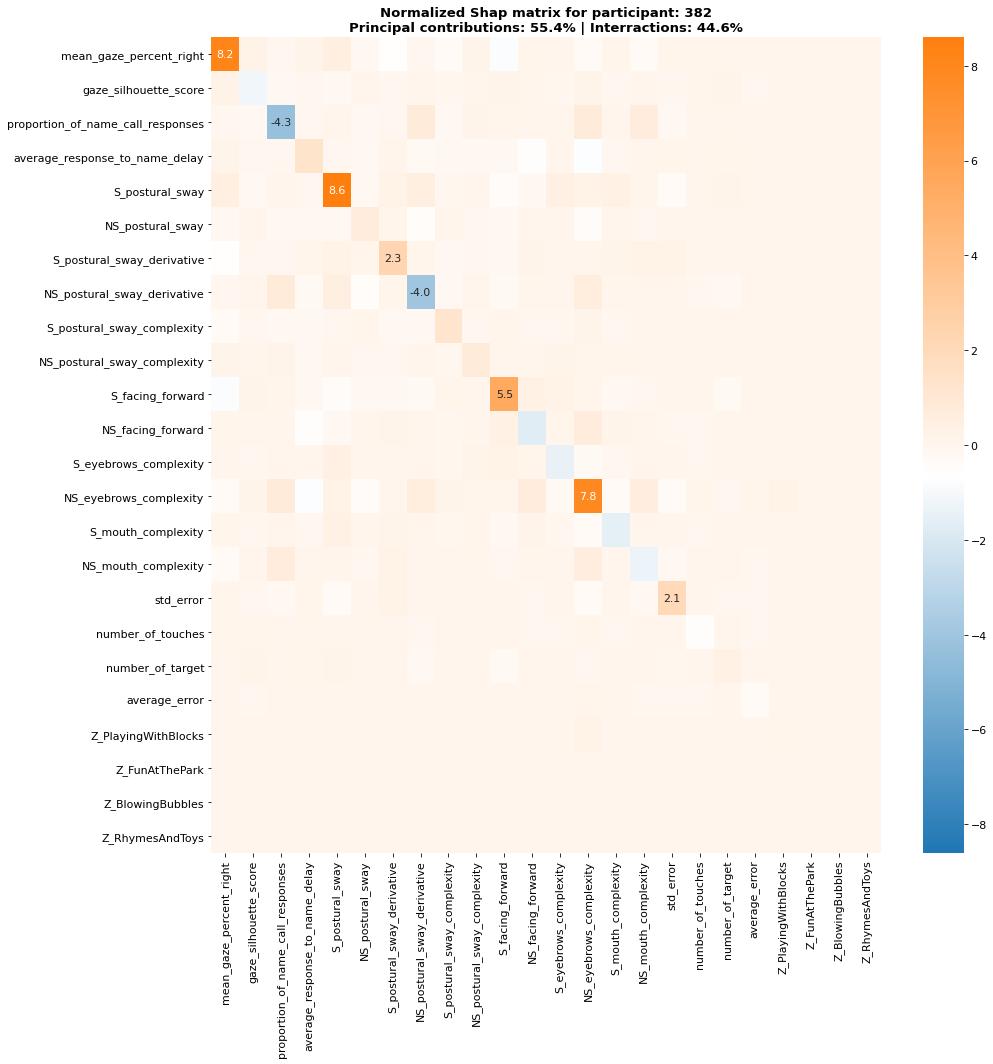

,total,main,interaction,first_interaction,first_interaction_name
NS_eyebrows_complexity,13.906024,7.795833,6.110191,0.755851,average_response_to_name_delay
S_postural_sway,12.297345,8.600631,3.696714,0.490219,mean_gaze_percent_right
mean_gaze_percent_right,12.12591,8.193795,3.932116,0.827978,S_facing_forward
S_facing_forward,8.676441,5.4959,3.180541,0.827979,mean_gaze_percent_right
proportion_of_name_call_responses,7.413683,4.3112,3.102483,0.789957,NS_postural_sway_derivative
NS_postural_sway_derivative,7.223991,4.021013,3.202978,0.789957,proportion_of_name_call_responses
S_postural_sway_derivative,4.712761,2.343349,2.369411,0.55006,mean_gaze_percent_right
NS_facing_forward,4.149236,1.698625,2.450611,0.738939,NS_eyebrows_complexity
average_response_to_name_delay,4.068166,1.302438,2.765728,0.755851,NS_eyebrows_complexity
std_error,3.697063,2.08247,1.614594,0.331683,NS_eyebrows_complexity


In [38]:

# Draw a random smaple and plot the shap matrix
matrix_shap = exp.shap_interaction_value[index_sample]*100

# Build the anotation matrix for ploting
max_value = np.max(np.abs(matrix_shap))
df_shap = pd.DataFrame(matrix_shap, columns = exp.features_name, index = exp.features_name)
df_shap_label = np.zeros_like(matrix_shap).astype(str)
for row in range(matrix_shap.shape[0]):
    for col in range(matrix_shap.shape[0]):

        if np.abs(matrix_shap[row, col]) > 2: 
            df_shap_label[row, col] = str(np.round(matrix_shap[row, col], 1))
        else:
            df_shap_label[row, col] = ""

principal_effect_sum = np.diag(np.abs(matrix_shap)).sum()
interaction_effect_sum = np.abs(matrix_shap).sum() - np.diag(np.abs(matrix_shap)).sum()

fi(15, 15)
plt.title("Normalized Shap matrix for participant: {}\nPrincipal contributions: {:.1f}% | Interractions: {:.1f}%".format(index_sample, principal_effect_sum, interaction_effect_sum), weight='bold')
sns.heatmap(df_shap, cmap=cmap, vmin=-max_value, vmax=max_value, fmt="", annot=df_shap_label)
plt.show()
display_interaction_summary(matrix_shap)


**Show the participant data into the distributions**

<AxesSubplot:xlabel='mean_gaze_percent_right', ylabel='Density'>

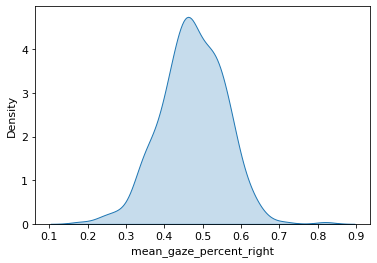

In [73]:
sns.kdeplot(data=exp.predictions_df, x=feat, common_norm=1, fill=True)


In [59]:
pip install --upgrade seaborn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 5.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.11.1
    Uninstalling seaborn-0.11.1:
      Successfully uninstalled seaborn-0.11.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
responsibly 0.1.3 requires matplotlib<3,>=2.2, but you have matplotlib 3.5.3 which is incompatible.
Note: you may need to restart the kernel to use updated packages.


In [39]:
feat = exp.features_name[0]

In [52]:
n_asd = np.sum(exp.predictions_df['y_true'])
n_nt = np.sum(exp.predictions_df['y_true']==0)
n_tot = n_asd+n_nt

weights = [n_asd/n_tot if y==0 else n_nt/n_tot for y in exp.predictions_df['y_true']]
weights

[0.14432989690721648,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.8556701030927835,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.14432989690721648,
 0.144329896907216